## Import Libraries

In [877]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import plotly.offline as py
from datetime import datetime
import scipy.stats
import warnings
warnings.filterwarnings('ignore')

## Part 1. Load and Clean Data

>  ## Datasets
> #### Since I am interested in the Covid 19 trend in Canada, my research is based on Canadian datasets.
- Covid 19 Cases in Canada Datasets (confirmed, recovered, deceased cases; and I created active infected column to get data prepared for SIR model) 
- Apple Mobility Trend Dataset (related to three transportation types:dring, transit, walking)
- Google Community Mobility Trend Dataset (including five communities)

### 1.Covid 19 Cases in Canada Datasets

#### Access Canada Confirmed Cases Data from Global Confirmed Cases Dataset

In [985]:
globalconfirm = pd.read_csv('time_series_covid19_confirmed_global.csv')
canadaconfirm=globalconfirm[globalconfirm['Country/Region']=='Canada']  
canadaconfirm=pd.DataFrame(canadaconfirm.iloc[:,4:].sum(axis=0))    # add the number of all provinces in Canada on the same day
canadaconfirm=canadaconfirm.reset_index()
canadaconfirm.columns=['date','confirmed number']                   #reset index and add 'date' column to prepare for the difference plot of canadaconfirm data in Part 2

for i in range(len(canadaconfirm)):
     canadaconfirm.date[i]=pd.to_datetime(canadaconfirm.date[i]).date()        #Change date to datetime format

#### Access Canada Recovered Cases Data from Global Recovered Cases Dataset

In [976]:
recover=pd.read_csv('time_series_covid19_recovered_global.csv')
canadarecover=recover[recover['Country/Region']=='Canada'].transpose()
canadarecover=canadarecover.iloc[4:,:]                #index data until 12/10/20
canadarecover=canadarecover.reset_index()              #reset index for canadarecover dataset
canadarecover.columns=['date','recovered number'] 

for i in range(len(canadarecover)):
     canadarecover.date[i]=pd.to_datetime(canadarecover.date[i]).date()         #change date to datetime format

#### Acess Canada Deceased Cases Data from Global Deceased Cases Dataset

In [977]:
death=pd.read_csv('time_series_covid19_deaths_global.csv')
canadadeath=death[death['Country/Region']=='Canada']
canadadeath=pd.DataFrame(canadadeath.iloc[:,4:].sum(axis=0))   #index data until 12/10/20 
canadadeath.columns=['death number']
canadadeath=canadadeath.reset_index()                        #reset index and add 'date' column
canadadeath.columns=['date','death number'] 

for i in range(len(canadadeath)):
     canadadeath.date[i]=pd.to_datetime(canadadeath.date[i]).date()    #change date to datetime Format

#### Merge Dataframes Above

In [978]:
canada_covid1=pd.merge(canadaconfirm,canadadeath,on='date',how='left')
canada_covid1.columns=['date','confirmed number','death number']
canadarecover.columns=['date','recovered number']
canada_covid2=pd.merge(canada_covid1,canadarecover,on='date',how='outer')
canada_covid2.columns=['date','confirmed number','death number','recovered number']
canada_covid2

,date,confirmed number,death number,recovered number
0,2020-01-22,0,0,0
1,2020-01-23,0,0,0
2,2020-01-24,0,0,0
3,2020-01-25,0,0,0
4,2020-01-26,1,0,0
...,...,...,...,...
319,2020-12-06,418848,12688,334375
320,2020-12-07,426572,12796,344034
321,2020-12-08,432743,12887,349629
322,2020-12-09,439142,13009,355401


#### Add a New Column (Active Infected) to Original Dataframe

In [980]:
active=[]
for i in range(len(canada_covid2)):
    active.append(canada_covid2['confirmed number'][i]-canada_covid2['death number'][i]-canada_covid2['recovered number'][i])
    
canadaactive=pd.DataFrame({'date':canada_covid2.date,'active infected':active})
canada_covid2['active infected']=active
canada_covid2

,date,confirmed number,death number,recovered number,active infected
0,2020-01-22,0,0,0,0
1,2020-01-23,0,0,0,0
2,2020-01-24,0,0,0,0
3,2020-01-25,0,0,0,0
4,2020-01-26,1,0,0,1
...,...,...,...,...,...
319,2020-12-06,418848,12688,334375,71785
320,2020-12-07,426572,12796,344034,69742
321,2020-12-08,432743,12887,349629,70227
322,2020-12-09,439142,13009,355401,70732


### 2. Apple Mobility Trend Dataset

#### Load Data

In [826]:
#data source:https://covid19.apple.com/mobility

mobility=pd.read_csv('applemobilitytrends-2020-12-16.csv')

#### Access Mobility Data in Canada

In [188]:
canada_mobility=mobility[mobility['region']=='Canada'].iloc[:,6:].transpose().reset_index()     #the data on Jan 13th is a base
canada_mobility.columns=['date','driving','transit','walking']
canada_mobility             

,date,driving,transit,walking
0,2020-01-13,100.00,100.00,100.00
1,2020-01-14,102.91,100.03,106.29
2,2020-01-15,99.74,98.01,106.65
3,2020-01-16,105.17,101.01,108.64
4,2020-01-17,122.34,105.42,127.43
...,...,...,...,...
334,2020-12-12,97.08,36.68,100.77
335,2020-12-13,74.42,32.17,76.18
336,2020-12-14,92.84,38.52,94.26
337,2020-12-15,97.53,37.69,96.07


#### Detect Missing Values

In [44]:
# there are two missing records

canada_mobility[canada_mobility.driving.isnull()]

,date,driving,transit,walking
119,2020-05-11,NaN,NaN,NaN
120,2020-05-12,NaN,NaN,NaN


#### Deal with Missing Values

In [829]:
# since the data on May 11th and May 12th is missing, I chose to replace it with the mean value of 8 nearest neighbors(4+4).

for i in range(0,3):
     canada_mobility.iloc[119,i+1]= (canada_mobility.iloc[114:118,i+1].sum()+canada_mobility.iloc[121:125,i+1].sum())/8
     
    
for i in range(0,3):
     canada_mobility.iloc[120,i+1]= (canada_mobility.iloc[115:119,i+1].sum()+canada_mobility.iloc[121:125,i+1].sum())/8
        
canada_mobility.iloc[119:121]

,date,driving,transit,walking
119,2020-05-11,83.84625,25.15375,78.56500
120,2020-05-12,82.02500,24.68625,76.43375


Now the data is ready for the next step.

## Part 2. Data Visualization and Exploratory Data Analysis

> ### Visualization 
>
> In this part, I visualized different datasets with four plots.
- The Cumulative Number of Confirmed and Recovered Cases in Canada.
- The Cumulative Number of Active Infected and Deceased Cases in Canada
- Daily Increase of the Confirmed Cases in Canada
- Mobility Data Trend in Canada with respect to Transportation Types

### 1.The Cumulative Number of Confirmed and Recovered Cases in Canada

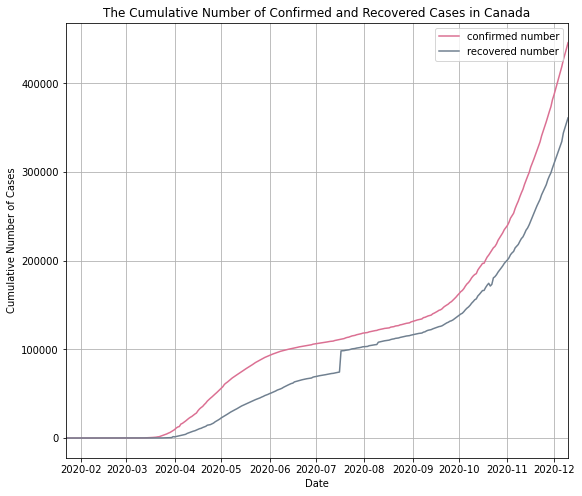

In [981]:
canada_covid2.plot(x='date',y=['confirmed number','recovered number'],color=['palevioletred','slategray'],figsize=(9,8))
plt.xlabel('Date')
plt.ylabel('Cumulative Number of Cases')
plt.title('The Cumulative Number of Confirmed and Recovered Cases in Canada')
plt.grid(True)
plt.show()

- #### From this plot, we can see how the trend of cumulative confirmed cases and recovered cases goes in Canada. The slope of these two lines both decrease at first, and then increase from around mid July. Thus we can roughly conclude that mid July is an important turning point, and this conclusion is important when we decide which period to fit in Part3. ####

### 2.The Cumulative Number of Active Infected and Deceased Cases in Canada

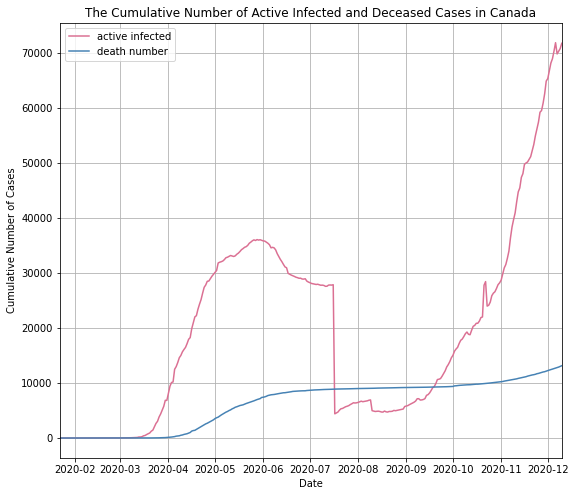

In [982]:
canada_covid2.plot(x='date',y=['active infected','death number'],color=['palevioletred','steelblue'],figsize=(9,8))
plt.xlabel('Date')
plt.ylabel('Cumulative Number of Cases')
plt.title('The Cumulative Number of Active Infected and Deceased Cases in Canada')
plt.grid(True)
plt.show()

- #### I plotted the cumulative number of active infected and deceased cases because in Part3, I would use the SIR model, in which 'I' refers to active infected and 'R' includes recovered and deceased cases. From this plot, we can find that the number of active infected cases in Canada experience two waves, the first highest peak is around early June, and the second wave starts from mid July. Thus I decided to fit the data after mid July in Part3. ####

### 3.Daily Increase of the Confirmed Cases in Canada

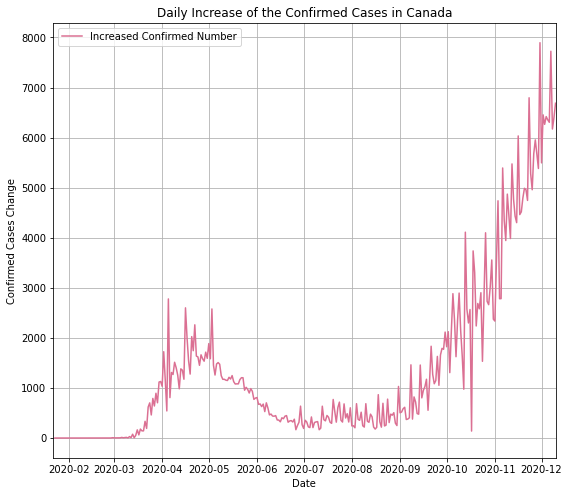

In [991]:
canadaconfirm['increased confirm']=canadaconfirm.iloc[:,1].diff()
canadaconfirm.plot(x='date',y=['increased confirm'],color=['palevioletred'],figsize=(9,8))
plt.xlabel('Date')
plt.ylabel('Confirmed Cases Change')
plt.title('Daily Increase of the Confirmed Cases in Canada')
plt.legend(['Increased Confirmed Number'])
plt.grid(True)

- #### The trend of increased number of confirmed cases is very similar to the trend of active infected cases, which is the number increased until it reached a peak, and then it shrank to the lowest in July, and increased again after July. From the plots above, the increased number of confirmed cases is more meaningful to me, so I would explore the correlation of increased number of confirmed cases with other factors in Part4. ####

### 4.Mobility Data Trend in Canada with respect to Transportation Types

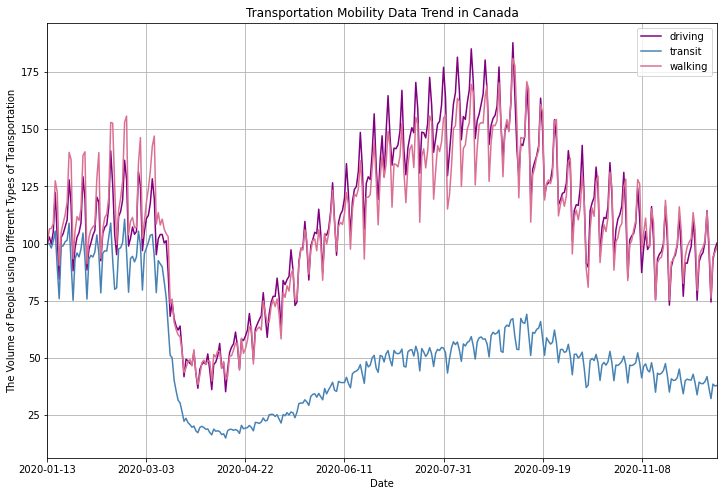

In [993]:
canada_mobility.plot(x='date',color=['purple','steelblue','palevioletred'],figsize = (12, 8))
plt.xlabel('Date')
plt.ylabel('The Volume of People using Different Types of Transportation')
plt.title('Transportation Mobility Data Trend in Canada')
plt.grid(True)
plt.show()

- #### This plot visualized how the volume of people using different types of transportation including driving, transit and walking changes as time changes. The trend of 'driving' is quite similar to  'walking'. And the volume of people with transit decreased a lot since March. Intuitively, the trend can be related to the trend of increased confirmed data or active infected data. But since the peak and the bottom are not in the same time period with increased confirm data trend, we can guess there might exist time delay.

## Part 3. Model Selection and Fitting to Data

> ### Algorithm 
>
>In this part, I chose SIR model to fit and predict the time series data.
>
>- #### SIR Model: SIR model divides the (fixed) population of N individuals into three "compartments" which may vary as a function of time, t
> S = S(t) : the number of susceptible individuals  <br>
> I = I(t) : the number of infected individuals   <br>
> R = R(t) : the number of removed individuals including recovered and deceased individuals   <br>

>- #### Parameters: The SIR model describes the change in the population of each of these compartments in terms of two parameters, β and γ 
> β beta : the effective contact rate = risk of infection*contact rate (Per capita rate of infection given contact)    <br>
> γ gamma : the removal rate = 1/removal period (recovered or deceased) <br>
> R0: the basic reproduction number = the effective contact rate/the recovery rate= β/γ  (The average number of people who contract a contagious disease from one person with that disease.)

>- #### Fomula: 
> #### $\frac{\mathrm{d}S}{\mathrm{d}t} = -\frac{βSI}{N}$       
> ####   $\frac{\mathrm{d}I}{\mathrm{d}t} = \frac{βSI}{N}-γI$
> #### $\frac{\mathrm{d}R}{\mathrm{d}t} = γI$  
>

> ### Procedure and Approach
>
>  ####  Base Case Spread: For base case spread, I would fit the model with the data from July 17 to Nov.17, and predict the trend from Nov.18 to Dec 10 and the future trend until 2022-01-15. 
>- **Loss Function:** The loss function I defined would return the mean value of the RMSE(Root Mean Square Deviation) values of β and γ.
>- **Minimize Loss Function:** We can get optimal values of β and γ by minimizing the loss function, and the method I chose is'L-BFGS-B'.
>- **Actual-fit Function:** This function I defined is to fit the model with the data from July 17 to Nov.17.
>- **Fit-train Function:** Using this function, we can get the visualization result of fitted and predicted data and the value of beta, gamma and R0.

>  #### Best Case Spread: For best case spread, the time length doesn't change. I changed the parameter R0 based on the data on the website: https://www.refinery29.com/en-ca/when-will-coronavirus-end-quarantine-canada , which indicates the R0 value for Canada is between 1.1 and 1.5 nationally. So I changed R0 to be 1.1 to get the best case projection.
>
>  #### Worst Case Spread:For worst case spread, according to the above data source, I would change R0 to be 1.5.
>
>
> ### Discussion and Interpretation

### 1. Base Case Spread

#### Access the Data I Want to Fit the Model 

In [995]:
# since we can see from the above plot that the second wave started around mid July, I chose to fit the model from July 17 to November 17th, and predict the rest of the period and the future trend

for i in range(len(canada_covid2)):
     canada_covid2.date[i]=pd.to_datetime(canada_covid2.date[i]).date()
        
canada_covid3=canada_covid2.iloc[177:301]
canada_covid3

,date,confirmed number,death number,recovered number,active infected
177,2020-07-17,111559,8884,98281,4394
178,2020-07-18,111875,8892,98436,4547
179,2020-07-19,112168,8896,98564,4708
180,2020-07-20,112938,8902,98975,5061
181,2020-07-21,113473,8908,99248,5317
...,...,...,...,...,...
296,2020-11-13,290709,10885,234404,45420
297,2020-11-14,295139,10947,236870,47322
298,2020-11-15,299440,11001,240434,48005
299,2020-11-16,305473,11075,244699,49699


In [1005]:
infected = canada_covid3.set_index('date')['active infected']
removed = canada_covid3.set_index('date')['recovered number']+canada_covid3.set_index('date')['death number']
time1 = np.array(list(infected.index.values)+list(np.array(pd.date_range(start='2020-11-18',end='2022-01-15').strftime('%Y-%m-%d'))))     #the prediction length

### Define Original Values of s0,i0,r0 and N0

#### According to the link, the population of Canada in 2020 is 37742154 .
https://www.worldometers.info/world-population/canada-population/#:~:text=Canada%202020%20population%20is%20estimated,(and%20dependencies)%20by%20population.

In [1023]:
N0= 37742154
i0 = 4394         #the data on 2020-07-17
r0 = 8884+98281
s0 = N0-i0-r0

### Fit the Model and Make Predictions

In [1024]:
def loss(parameter, infected, removed, s0, i0, r0):
    beta,gamma=parameter
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I/s0, beta*S*I/s0-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, len(infected)], [s0,i0,r0], t_eval=np.arange(0, len(infected), 1), vectorized=True)  
    m = np.sqrt(np.mean((solution.y[1] - infected)**2))
    n = np.sqrt(np.mean((solution.y[2] - removed)**2))                            
    return 0.5* m + 0.5 * n                                 #give the same weight to infected and removed(mean of RMSE of m and n)

optimal = minimize(loss, [0.05, 0.05], args=(infected,removed, s0, i0, r0), method='L-BFGS-B',bounds=[(0.0000001, 1.0), (0.0000001, 0.2)])   #I assume the minimum recovery period is 3 days, thus the upper bound of gamma is 0.2
beta,gamma = optimal.x

In [1035]:
def actual_fit(beta,gamma, infected, removed, s0, i0, r0): 
    new_index = time1
    def SIR(t,y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I/s0, beta*S*I/s0-gamma*I, gamma*I]
    fit_infected = np.concatenate((infected.values,[None] * (len(new_index)- len(infected.values))))
    fit_removed = np.concatenate((removed.values,[None] * (len(new_index) - len(removed.values))))
    return new_index, fit_infected, fit_removed, solve_ivp(SIR, [0, len(new_index)], [s0,i0,r0], t_eval=np.arange(0, len(new_index), 1))   #solve_ivp here is to make predictions 

infected2=canada_covid2.iloc[177:].set_index('date')['active infected']     #to plot the actual infected from July 17 to Dec 10
    
def fit_train(removed, infected):                                     
    removed = removed
    infected = infected
    new_index, fit_infected, fit_removed, prediction = actual_fit(beta, gamma, infected, removed, s0, i0, r0)
    actual_infected=np.concatenate((infected2.values,[None] * (len(new_index)- len(infected2.values))))
    df1 = pd.DataFrame({'Actual Infected':  actual_infected, 'Predicted Infected': prediction.y[1]},index=new_index)
    df2 = pd.DataFrame({'Actual Removed': fit_removed, 'Predicted Recovered': prediction.y[2],'Susceptible': prediction.y[0]},index=new_index)
    fig, axes = plt.subplots(1,2,figsize=(20,8))
    df1[['Actual Infected','Predicted Infected']].plot(ax=axes[0],color=['darkmagenta','salmon'])
    df2[['Actual Removed','Predicted Recovered','Susceptible']].plot(ax=axes[1],color=['steelblue','lightsalmon','palevioletred'])
    axes[0].legend(['Actual Infected','Predicted Infected'])
    axes[0].set_title('Actual Infected VS. Predicted Infected in Canada',color='midnightblue',fontsize=14)
    axes[1].legend(['Actual Removed(Recovered+Deceased)','Predicted Removed(Recovered+Deceased)','Susceptible'])
    axes[1].set_title('Actual Removed VS. Predicted Removed & Susceptible in Canada',color='midnightblue',fontsize=13)
    print(f" beta={beta:.4f} \n gamma={gamma:.4f} \n R0:{(beta/gamma):.4f}")
    print(' Maximum infected proportion of the population at a time is: {}%'.format(round((prediction.y[1].max()/N0)*100,2)))

 beta=0.0848 
 gamma=0.0658 
 R0:1.2900
 Maximum infected proportion of the population at a time is: 2.75%


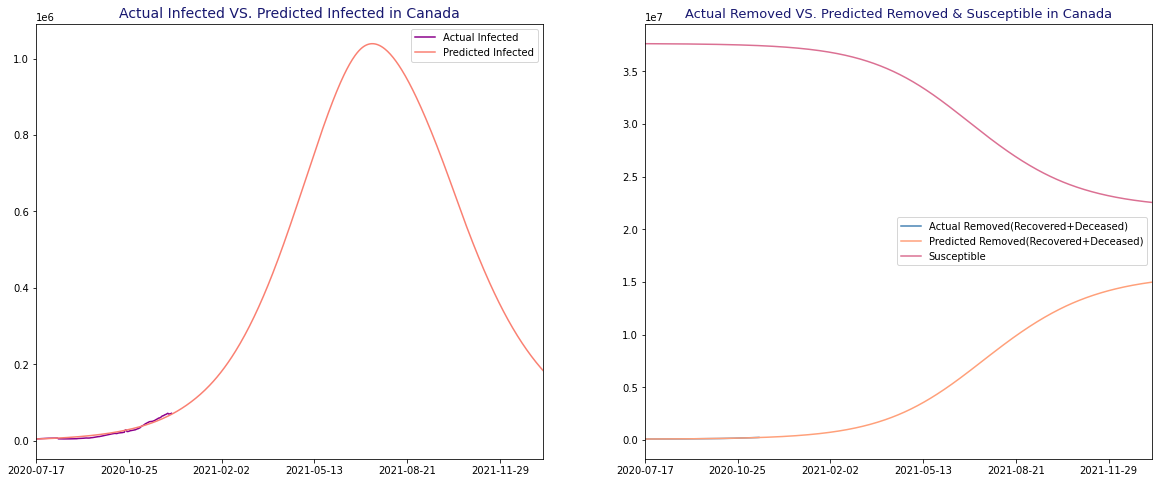

In [1036]:
fit_train(removed, infected)

#### Interpretation of Results: For base case, from the plot above, we can see the SIR model fits well, and the maximum infected proportion of the population at a time is 2.75% out of the total population, which is around 1037910 individuals. And the optimal beta is 0.0848, gamma is 0.0658, which means the recovery period is around 15.20 days and the effective contact rate is 0.0848. Since R0 is 1.2900 more thant 1, it means each existing infection causes more than one new infection. The disease will be transmitted between people.To be specific, it means one person with COVID-19 can potentially transmit the coronavirus to an average of 1.29 other people or 1 to 2 people. And the peak is around Jule in 2021 and the pandemic will not end before 2021 December.

#### From the website, we know that R0 for Canada is roughly between 1.1 and 1.5 nationally, thus I chose R0 to be 1.1 for the best case, and R0 to be 1.5 for the worst case. gamma = 0.0658 is not changed since that means the removal period is around 15.20 days, which is reasonable.

https://www.refinery29.com/en-ca/when-will-coronavirus-end-quarantine-canada

### 2. Best Case Spread
#### R0=1.1

In [1010]:
R0=1.1
gamma=0.0658
beta=R0*gamma

N0= 37742154
i0 = 4394
r0 = 8884+98281
s0 = N0-i0-r0

In [1011]:
def actual_fit(beta,gamma, infected, removed, s0, i0, r0): 
    new_index = np.array(list(infected.index.values)+list(np.array(pd.date_range(start='2020-11-10',end='2023-12-15').strftime('%Y-%m-%d'))))
    def SIR(t,y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I/s0, beta*S*I/s0-gamma*I, gamma*I]
    fit_infected = np.concatenate((infected.values,[None] * (len(new_index)- len(infected.values))))
    fit_removed = np.concatenate((removed.values,[None] * (len(new_index) - len(removed.values))))
    return new_index, fit_infected, fit_removed, solve_ivp(SIR, [0, len(new_index)], [s0,i0,r0], t_eval=np.arange(0, len(new_index), 1))

    
def fit_train(removed, infected):
    removed = removed
    infected = infected
    new_index, fit_infected, fit_removed, prediction = actual_fit(beta, gamma, infected, removed, s0, i0, r0)
    df1 = pd.DataFrame({'Actual Infected': fit_infected, 'Predicted Infected': prediction.y[1]}, index=new_index)
    df2 = pd.DataFrame({'Actual Removed': fit_removed, 'Predicted Recovered': prediction.y[2],'Susceptible': prediction.y[0]},index=new_index)
    fig, axes = plt.subplots(1,2,figsize=(20,8))
    df1[['Actual Infected','Predicted Infected']].plot(ax=axes[0],color=['darkmagenta','salmon'])
    df2[['Actual Removed','Predicted Recovered','Susceptible']].plot(ax=axes[1],color=['steelblue','lightsalmon','palevioletred'])
    axes[0].legend(['Actual Infected','Predicted Infected'])
    axes[0].set_title('Best Case: \n Actual Infected VS. Predicted Infected in Canada',color='midnightblue',fontsize=14)
    axes[1].legend(['Actual Removed(Recovered/Deceased)','Predicted Removed(Recovered/Deceased)','Susceptible'])
    axes[1].set_title('Best Case: \n Actual Removed VS. Predicted Removed & Susceptible in Canada',color='midnightblue',fontsize=13)
    print(f" beta={beta:.4f} \n gamma={gamma:.4f} \n R0:{(beta/gamma):.4f}")    
    print(' Maximum infected proportion of the population at a time is: {}%'.format(round((prediction.y[1].max()/N0)*100,2)))

 beta=0.0724 
 gamma=0.0658 
 R0:1.1000
 Maximum infected proportion of the population at a time is: 0.44%


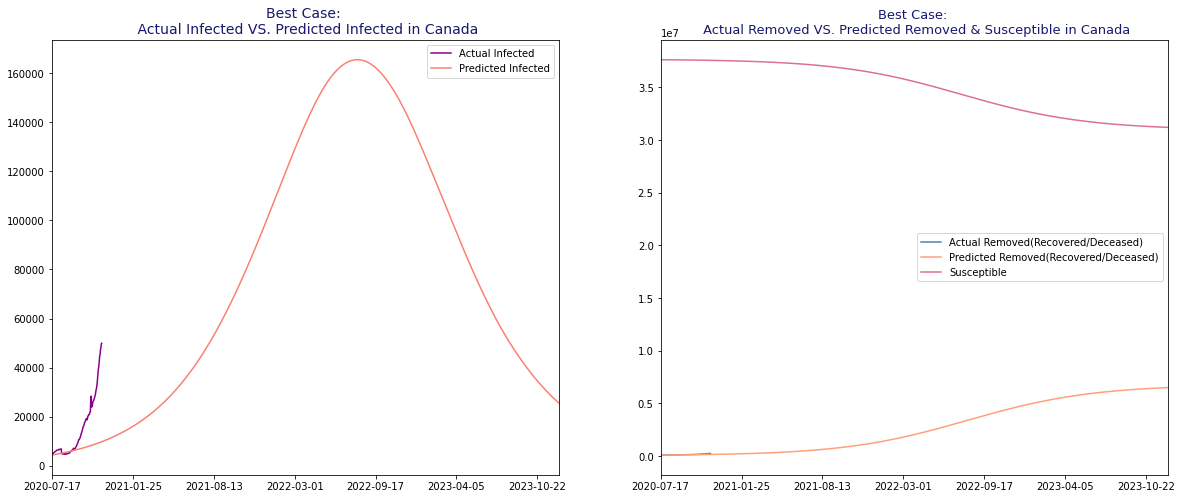

In [1012]:
fit_train(removed, infected)

#### Interpretation of Results: For best case spread, since R0 is changed to 1.1, which means one person with COVID-19 can potentially transmit the coronavirus to an average of 1.1 other people. beta also decreases from 0.0848 to 0.0724, which means the effective contact rate is 0.0724. And the maximum infected proportion also decreases from 2.75% to 0.44%, which is around 166065 individuals. Thus we can see by reducing the value of R0, the proportion of infected shrank greatly. Thus all the policies and measures should be taken in order to reduce R0.

### 3. Worst Case Spread
#### R0=1.5

In [1038]:
R0=1.5
gamma=0.0658
beta=R0*gamma

N0= 37742154
i0 = 4394
r0 = 8884+98281
s0 = N0-i0-r0

In [1039]:
def actual_fit(beta,gamma, infected, removed, s0, i0, r0): 
    new_index = np.array(list(infected.index.values)+list(np.array(pd.date_range(start='2020-11-10',end='2023-06-15').strftime('%Y-%m-%d'))))
    def SIR(t,y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I/s0, beta*S*I/s0-gamma*I, gamma*I]
    fit_infected = np.concatenate((infected.values,[None] * (len(new_index)- len(infected.values))))
    fit_removed = np.concatenate((removed.values,[None] * (len(new_index) - len(removed.values))))
    return new_index, fit_infected, fit_removed, solve_ivp(SIR, [0, len(new_index)], [s0,i0,r0], t_eval=np.arange(0, len(new_index), 1))

    
def fit_train(removed, infected):
    removed = removed
    infected = infected
    new_index, fit_infected, fit_removed, prediction = actual_fit(beta, gamma, infected, removed, s0, i0, r0)
    df1 = pd.DataFrame({'Actual Infected': fit_infected, 'Predicted Infected': prediction.y[1]}, index=new_index)
    df2 = pd.DataFrame({'Actual Removed': fit_removed, 'Predicted Recovered': prediction.y[2],'Susceptible': prediction.y[0]},index=new_index)
    fig, axes = plt.subplots(1,2,figsize=(20,8))
    df1[['Actual Infected','Predicted Infected']].plot(ax=axes[0],color=['darkmagenta','salmon'])
    df2[['Actual Removed','Predicted Recovered','Susceptible']].plot(ax=axes[1],color=['steelblue','lightsalmon','palevioletred'])
    axes[0].legend(['Actual Infected','Predicted Infected'])
    axes[0].set_title('Worst Case: \n Actual Infected VS. Predicted Infected in Canada',color='midnightblue',fontsize=14)
    axes[1].legend(['Worst Case: \n Actual Removed(Recovered/Deceased)','Predicted Removed(Recovered/Deceased)','Susceptible'])
    axes[1].set_title('Actual Removed VS. Predicted Removed & Susceptible in Canada',color='midnightblue',fontsize=13)
    print(f" beta={beta:.4f} \n gamma={gamma:.4f} \n R0:{(beta/gamma):.4f}")    
    print(' Maximum infected proportion of the population at a time is: {}%'.format(round((prediction.y[1].max()/N0)*100,2)))

 beta=0.0987 
 gamma=0.0658 
 R0:1.5000
 Maximum infected proportion of the population at a time is: 6.32%


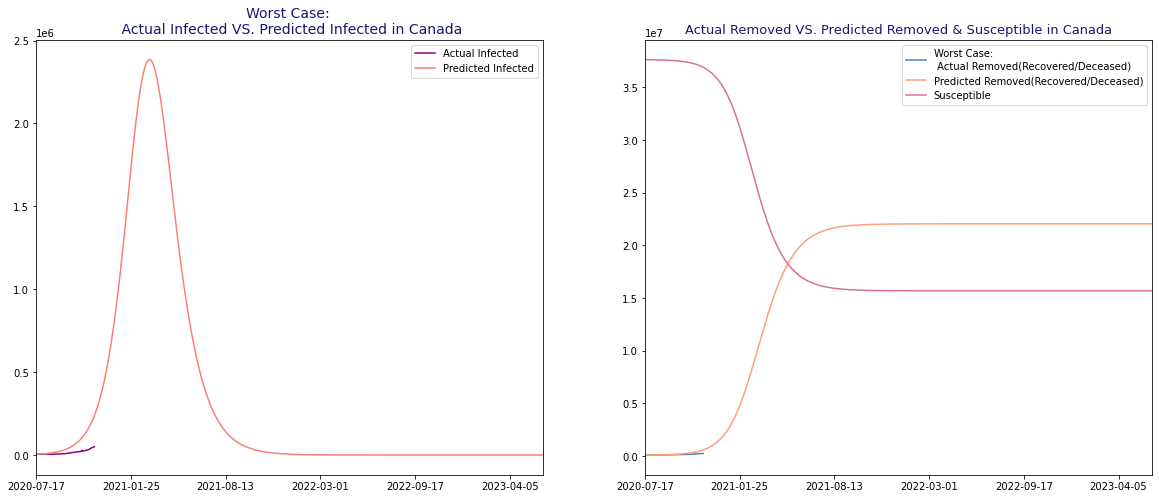

In [1040]:
fit_train(removed, infected)

#### Interpretation of Results: For worst case spread, R0 is changed to 1.5, which means one person with COVID-19 can potentially transmit the coronavirus to an average of 1.5 other people. beta increases from 0.0848 of the base model to 0.0987 of this model, which means the effective contact rate(per capita rate of infection given contact) is 0.0987. The maximum infected proportion at a time is 6.32% out of the total population, which is 2385304 individuals. And the removed proportion increases compared to the other two projections, which means the number of the recovered or the deceased people is growing. But the total end date of the pandemic will be before 2022-01.



## Part 4. Relating COVID-19 Projections to a Second Dataset

> ### Concept
>- Time-Lag: Time lag is an interval of time between two related phenomena. To be specific, a 'lag' is a fixed amount of passing time, it can be regarded as a time delay which can be found on many activity relationship types.

> ### Procedure
>**Factor 1. Transpotation Mobility**
>- Access canada_mobility Data from 2020-3-12 to 2020-12-10
>- Merge the Data with canada_covid2 Data
>- Calculate the Correlation Coefficients between Increased Confirmed Cases Number and Lagged Data
>- Plot Correlation and Ouput the Maximum Correlation Coefficients 
>
>**Factor 2. Social Distance Metric**
>- According to the website, the risk of being infected is estimated to be 13% within 1m, but only 3% beyond that distance. And the study says that for every extra metre of distance up to 3m, the risk is further reduced by half.
>
> ### Results
> The lag 143 of 'driving' is most correlated with increased confirmed cases. 
> The maximum correlation coefficient is 0.9252401306277778.
>
> The lag 133 of 'transit' is most correlated with increased confirmed cases.
> The maximum correlation coefficient is 0.7968696544354402. 
>
> The lag 143 of 'walking' is most correlated with increased confirmed cases. 
>  The maximum correlation coefficient is 0.9064202210491603. 

### Factor 1: Transpotation Mobility 

#### Access canada_mobility Data from 2020-3-12 to 2020-12-10

In [1049]:
canada_mobility_new=canada_mobility.iloc[59:333].reset_index()            #start from 2020-3-12 to 2020-12-10
for i in range(len(canada_mobility_new)):
    canada_mobility_new.date[i]=pd.to_datetime(canada_mobility_new.date[i]).date()    #change date to datetime format

#### Access canada_covid2 Data from 2020-3-12 to 2020-12-10

In [1051]:
canada_covid4=canada_covid2.iloc[50:].reset_index().iloc[:,1:]
for i in range(len(canada_covid4)):
     canada_covid4.date[i]=pd.to_datetime(canada_covid4.date[i]).date()

#### Merge the Datasets

In [1052]:
correlation=pd.merge(canada_covid4,canada_mobility_new,on='date',how='left')
#as I mentioned before, I took the difference to explore the correlation between increased number of confirmed cases and the types of transportation
correlation['confirmed number']=correlation['confirmed number'].diff()      
 #since there is a NA in the confirmed number on 3-12 after I took the difference, I would start from 2020-03-13
correlation1=correlation.loc['1':'273',['date','confirmed number','driving','transit','walking']]  
correlation1

,date,confirmed number,driving,transit,walking
1,2020-03-13,76.0,101.24,76.40,104.32
2,2020-03-14,5.0,87.16,63.75,103.00
3,2020-03-15,54.0,68.17,51.19,73.82
4,2020-03-16,163.0,74.10,50.00,75.70
5,2020-03-17,63.0,67.21,40.26,65.68
...,...,...,...,...,...
269,2020-12-06,6305.0,75.19,33.84,79.47
270,2020-12-07,7724.0,91.92,39.37,94.47
271,2020-12-08,6171.0,94.69,38.76,96.79
272,2020-12-09,6399.0,96.15,38.70,98.44


#### Calculate the Correlation Coefficients between Increased Confirmed Cases Number and Lagged Volume of People Choosing Driving Data

In [1065]:
def crosscorr(x, y, lag,wrap=False):
    return  x.corr(y.shift(lag))

In [1066]:
lag=[]
corr1=[]
x=correlation1['confirmed number']
y=correlation1['driving']
for i in range(0,200):                #max_lag=200
    lag.append(i)
    corr1.append(crosscorr(x,y,lag[i]))

In [1067]:
corr1   

[-0.2692302143674755,
 -0.30092856691631703,
 -0.27929694614759537,
 -0.25905666270834893,
 -0.268623806199914,
 -0.2681632242625105,
 -0.2540229346616839,
 -0.2641915863800747,
 -0.2868257872596929,
 -0.2610535901573232,
 -0.23390434965932,
 -0.2428224092927971,
 -0.23966053092010764,
 -0.21556112377231101,
 -0.22462109578881176,
 -0.2434593055874753,
 -0.21345451017267034,
 -0.18080639312940053,
 -0.18677035057224048,
 -0.17937558905432616,
 -0.15234183785114613,
 -0.1578106578441956,
 -0.17457982522384258,
 -0.14062360196018756,
 -0.10377586352904425,
 -0.10842055700326204,
 -0.09938222395788199,
 -0.07300921767131058,
 -0.07251160138082505,
 -0.08356832858631534,
 -0.04936611642336019,
 -0.01664048586623154,
 -0.015998328080753514,
 -0.0072674253740901236,
 0.022051720685976283,
 0.021821079457955823,
 0.0060801483036512505,
 0.04619822253794784,
 0.08155852766372639,
 0.08565357571347343,
 0.09908620114554172,
 0.12191981071993811,
 0.12218442151993773,
 0.11039739806870938,
 0.14

#### Plot Driving Mobility's Correlation with Increased Confirmed Cases in Canada

Text(0.5, 1.0, "Driving Mobility's Correlation with \n Increased Confirmed Cases in Canada")

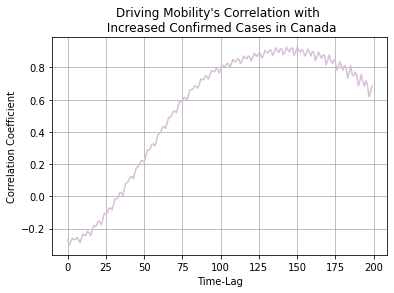

In [1068]:
plt.plot(lag,corr1,color='thistle')
plt.xlabel('Time-Lag')
plt.ylabel('Correlation Coefficient')
plt.grid(True)
plt.title("Driving Mobility's Correlation with \n Increased Confirmed Cases in Canada")

#### Calculate the Correlation Coefficients between Increased Confirmed Cases Number and Lagged Volume Data of People Choosing Transit 

In [1057]:
lag=[]
corr2=[]
x=correlation1['confirmed number']
y=correlation1['transit']
for i in range(0,200):
    lag.append(i)
    corr2.append(crosscorr(x,y,lag[i]))

In [1058]:
corr2

[-0.11411451814173605,
 -0.14095368894906912,
 -0.12389121483421951,
 -0.10034880725446428,
 -0.10213772500263034,
 -0.09520824477282201,
 -0.0748474652141015,
 -0.07237229053025308,
 -0.08561590998045826,
 -0.06798914444756311,
 -0.039948292228663945,
 -0.03812112382843303,
 -0.030846523673440956,
 -6.034577599050998e-05,
 0.0035432308262294105,
 -0.009386028701517718,
 0.013049250067869226,
 0.04691246246791083,
 0.04978826594341785,
 0.05951255297345044,
 0.09219929094961223,
 0.09267995872575559,
 0.07669433687822258,
 0.1058901657953863,
 0.12749596956019923,
 0.13019121828761346,
 0.14135290133677397,
 0.1715026316136524,
 0.17671617424542232,
 0.16480925967730004,
 0.1866866654491821,
 0.2154173020807814,
 0.22250132214275037,
 0.22945819083874971,
 0.263592167049997,
 0.26750870142397526,
 0.24372247884927897,
 0.2693359110529487,
 0.3002055685557405,
 0.30475256807585255,
 0.3189125836061685,
 0.3376415827732414,
 0.34509401687402697,
 0.3338497673291724,
 0.35597220983720074,

#### Plot Transit Mobility's Correlation with the Number of Increased Confirmed Cases in Canada

Text(0.5, 1.0, "Transit Mobility's Correlation with \n Increased Confirmed Cases in Canada")

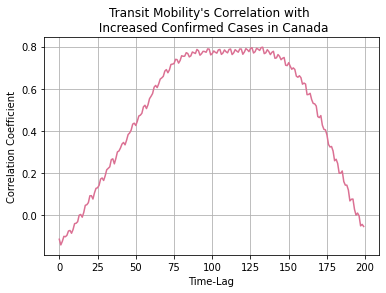

In [1069]:
plt.plot(lag,corr2,color='palevioletred')
plt.xlabel('Time-Lag')
plt.ylabel('Correlation Coefficient')
plt.grid(True)
plt.title("Transit Mobility's Correlation with \n Increased Confirmed Cases in Canada")

#### Calculate the Correlation Coefficients between Increased Confirmed Cases Number and Lagged Volume Data of People Choosing Walking

In [742]:
lag=[]
corr3=[]
x=correlation1['confirmed number']
y=correlation1['walking']
for i in range(0,200):
    lag.append(i)
    corr3.append(crosscorr(x,y,lag[i]))
    
corr3

[-0.20918055287476822,
 -0.24054749858502084,
 -0.20596911537386053,
 -0.18975415324811476,
 -0.2053619896373293,
 -0.20236016873178447,
 -0.18532164611785928,
 -0.20485714476568298,
 -0.22539303470609748,
 -0.1926080650208488,
 -0.17087097202761867,
 -0.1855746089059998,
 -0.17850915759026087,
 -0.15360798038272833,
 -0.17101269039470332,
 -0.18723188986528702,
 -0.14876188646039706,
 -0.11920617097233097,
 -0.13183442232443607,
 -0.11934761491167618,
 -0.08753400031538723,
 -0.10443762317708113,
 -0.11838666038896466,
 -0.07189593853178626,
 -0.04145697614900981,
 -0.05224529389541918,
 -0.03665449393760232,
 -0.007958755649831051,
 -0.01891493428630268,
 -0.02739056117457935,
 0.013828700789807242,
 0.03915793141119981,
 0.034176717252445685,
 0.042876492653859316,
 0.07380779810583465,
 0.05970768747216207,
 0.040090354737087656,
 0.09498211916471237,
 0.12387054286016798,
 0.12204958077834224,
 0.1400210088696896,
 0.1585501819143824,
 0.15282665628801015,
 0.1465003329761437,
 0.

#### Plot Walking Mobility's Correlation with the Number of Increased Confirmed Cases in Canada

Text(0.5, 1.0, "Walking Mobility's Correlation with \n Increased Confirmed Cases in Canada")

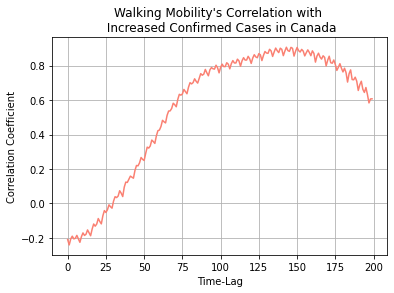

In [1070]:
plt.plot(lag,corr3,color='salmon')
plt.xlabel('Time-Lag')
plt.ylabel('Correlation Coefficient')
plt.grid(True)
plt.title("Walking Mobility's Correlation with \n Increased Confirmed Cases in Canada")

In [1063]:
#print the maximum correlation coefficients and the corresponding time lags

print(f" The lag {corr1.index(max(corr1))} of 'driving' is most correlated with increased confirmed cases \n The maximum correlation coefficient is {max(corr1)} \n\n The lag {corr2.index(max(corr2))} of 'transit' is most correlated with increased confirmed cases \n The maximum correlation coefficient is {max(corr2)} \n\n The lag {corr3.index(max(corr3))} of 'walking' is most correlated with increased confirmed cases \n The maximum correlation coefficient is {max(corr3)} ")

 The lag 143 of 'driving' is most correlated with increased confirmed cases 
 The maximum correlation coefficient is 0.9252401306277778 

 The lag 133 of 'transit' is most correlated with increased confirmed cases 
 The maximum correlation coefficient is 0.7968696544354402 

 The lag 143 of 'walking' is most correlated with increased confirmed cases 
 The maximum correlation coefficient is 0.9064202210491603 


**Result Analysis: From the output, we can see that the correlation between the number of increased confirmed cases and original mobility time series data which is not lagged is low. But after I took time lag into account, the correlation coefficient between 'driving' volume and increased confirmed cases can reach up to 0.9252401306277778, the maximum of which is attained with time lag equal to 143. And the maximum correlation coefficient between 'walking' volume and increased confirmed cases is 0.9064202210491603 with time lag also equal to 143. The result suggests that there exist strong correlation between voume of people choosing 'driving' and 'walking' and the number of increased confirmed cases. And there exists time delay phenomenon, too. Thus, the more people go out by driving or walking, the higher the risk of getting infected is. And for 'transit', the correlation coefficient is a little bit lower of 0.7968696544354402 with time lag equal to 133.** 

### Factor 2: Social Distance Metric

#### Data Source: https://www.bbc.com/news/science-environment-52522460
    
 According to the website, the risk of being infected is estimated to be 13% within 1m, but only 3% beyond that distance. And the study says that for every extra metre of distance up to 3m, the risk is further reduced by half. And in Canada, the standard social distance in the policy is 2 meters.

**Analysis: Thus if we all keep a social distance of 3 meters, the risk of infection will be reduced by half. According to the formula: (β) the effective contact rate = risk of infection*contact rate, since risk of infection is reduced by half, then β can be reduced by half if other factors remain unchanged. And since R0 =the effective contact rate/the removed rate, if removed rate is the same as before, then R0 will be reduced by half. In this way, the maximum proportion of people get infected at a time will be reduced a lot, and the curve will be flatterned.**

## Part 5. Insights about Policy and Guidance

>  ### 1. Findings and Insights about Guidance According to Analysis
>  **1) According to Part3, R0=β/γ, where β is the effective contact rate and γ is the removal rate. In order to reduce R0, we need to figure out ways to reduce β and increase γ.**
>- #### a. Ways to reduce β:  <br>
> Since β is equal to risk of infection*contact rate, we can try to reduce the risk of infection by developing vaccines and keeping a social distance with others. Since recently Canadian Government accessed a lot of COVID-19 vaccine, the government should encourage people to take vaccines if they are proved effective. And as I mentioned in Part 4, the study says for every extra metre of distance up to 3m, the risk is further reduced by half. Thus we need to avoid crowded places and keep a social distance with others as much as possible. On the other hand, we can also reduce contact rate by quarantine or isolation. And people should avoid non-essential gatherings to decrease the mean cantact.
>- #### b. Ways to increase γ: <br>
> Since γ=1/removal period, to increase γ is to reduce removal period. In this way, the doctors and healthcare professionals should try to develop more effective therapeutics , and the government need to assist scientists financially to develop more effective drugs against COVID-19 to reduce infectious period.
> 
> **2) According to Part4, the volume of people choosing driving or walking is highly positively correlated to the increased number of confirmed cases in Canada. In this way, people should try to avoid going out as much as possible since we are still in the dangerous "second wave" period. And entrepreneurs in different industries should promote online shopping and encourage the customers to buy things online. It is also a good opportunity to develop a new way of shopping instead of traditional shopping.**
>
>  ### 2. Proposed Policies or Actions Conclusion
>
>- **The Government:** <br>
> 1) Encourage people to take vaccines if they are proved effective in test.  <br>
> 2) Assist scientiest financially to develop more effective drugs against COVID-19.   <br>
> 3) Force all residents to keep social distance rules and severely punish those who violate the discipline.    <br>
> 4) Forbidden non-essential gatherings with more than 10 people (to decrease the mean contact).  <br>
>
>- **The Doctors or Healthcare Professinals:**  <br>
> Develop more effective therapeutics.<br>
>
>- **The Scientists:**  <br>
>  Spend more energy to develop more effective drugs against COVID-19 (to reduce infectious period). <br>
>
>- **The Industry:**   <br>
> Promote online shopping and encourage the customers to buy things online.
>
>- ** Residents:** <br>
> 1) Keep a social distance between each other as much as possible .
> 2) Avoid non-essential gatherings.
> 3) Reduce the activities which need people go out.
> 4) Buy things online instead of going to the store as much as possible.